---
title: "Training"
date: last-modified
format: 
    html: 
        code-fold: false
jupyter: python3
---

In [1]:
import numpy as np

import xgboost as xgb

#### DATA AND PARAMETERS

In [2]:
datatrain = np.random.rand(100, 5)
datatest = np.random.rand(20, 5)

labeltrain = np.random.randint(2, size=100)
labeltest = np.random.randint(2, size=20)

In [3]:
dtrain = xgb.DMatrix(data=datatrain, label=labeltrain, missing=np.NaN)
dtest = xgb.DMatrix(data=datatest, label=labeltest, missing=np.NaN)

In [4]:
params = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': ['auc', 'aucpr']
}

evallist = [
    (dtrain, 'train'),
    (dtest, 'test')
]

NUM_BOOST_ROUND = 500
EARLY_STOPPING_ROUNDS = 10

#### TRAINING A XGBOOST MODEL

- Validation error needs to decrease at least every `early_stopping_rounds` to continue training.
- If early stopping occurs, the model will have two additional fields: `bst.best_score`, `bst.best_iteration`. Note that `xgboost.train()` will return a model from the last iteration, not the best one.
- Note that if you specify more than one evaluation metric the last one in `params['eval_metric']` is used for early stopping.

In [5]:
bst = xgb.train(params, dtrain, NUM_BOOST_ROUND, evals=evallist, early_stopping_rounds=EARLY_STOPPING_ROUNDS)

[0]	train-auc:0.66954	train-aucpr:0.63223	test-auc:0.45000	test-aucpr:0.47214
[1]	train-auc:0.73337	train-aucpr:0.73544	test-auc:0.45500	test-aucpr:0.47955
[2]	train-auc:0.81486	train-aucpr:0.82001	test-auc:0.51000	test-aucpr:0.49078
[3]	train-auc:0.86494	train-aucpr:0.84077	test-auc:0.52000	test-aucpr:0.48684
[4]	train-auc:0.90558	train-aucpr:0.87932	test-auc:0.34000	test-aucpr:0.39197
[5]	train-auc:0.93719	train-aucpr:0.91281	test-auc:0.33000	test-aucpr:0.39475
[6]	train-auc:0.95033	train-aucpr:0.93645	test-auc:0.33000	test-aucpr:0.38466
[7]	train-auc:0.94992	train-aucpr:0.94102	test-auc:0.35000	test-aucpr:0.38874
[8]	train-auc:0.95998	train-aucpr:0.95181	test-auc:0.39000	test-aucpr:0.40416
[9]	train-auc:0.96613	train-aucpr:0.95756	test-auc:0.39000	test-aucpr:0.40416
[10]	train-auc:0.96880	train-aucpr:0.96532	test-auc:0.43000	test-aucpr:0.43488
[11]	train-auc:0.97455	train-aucpr:0.97430	test-auc:0.47000	test-aucpr:0.44865
[12]	train-auc:0.98727	train-aucpr:0.98742	test-auc:0.48000	te

In [6]:
bst.best_iteration

2

In [7]:
bst.best_score

0.4907757515714366

In [8]:
clf = xgb.XGBClassifier(n_estimators=NUM_BOOST_ROUND, missing=np.NaN, early_stopping_rounds=EARLY_STOPPING_ROUNDS, tree_method='gpu_hist', **params)
clf.fit(datatrain, labeltrain, eval_set=[(datatest, labeltest)])

[0]	validation_0-auc:0.45000	validation_0-aucpr:0.47214
[1]	validation_0-auc:0.45500	validation_0-aucpr:0.47955
[2]	validation_0-auc:0.44500	validation_0-aucpr:0.46638
[3]	validation_0-auc:0.46000	validation_0-aucpr:0.53426
[4]	validation_0-auc:0.27000	validation_0-aucpr:0.36721
[5]	validation_0-auc:0.27000	validation_0-aucpr:0.36733
[6]	validation_0-auc:0.36000	validation_0-aucpr:0.39953
[7]	validation_0-auc:0.39000	validation_0-aucpr:0.41427
[8]	validation_0-auc:0.44000	validation_0-aucpr:0.43541
[9]	validation_0-auc:0.41000	validation_0-aucpr:0.41381
[10]	validation_0-auc:0.41000	validation_0-aucpr:0.41305
[11]	validation_0-auc:0.37000	validation_0-aucpr:0.40028
[12]	validation_0-auc:0.38000	validation_0-aucpr:0.40333
[13]	validation_0-auc:0.37000	validation_0-aucpr:0.39811


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=1,
              eval_metric=['auc', 'aucpr'], feature_types=None, gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
              num_parallel_tree=1, ...)

In [9]:
clf.best_iteration

3

In [10]:
clf.best_score

0.5342577697455242

In [11]:
bst = clf.get_booster()

#### SAVING A XGBOOST MODEL

In [22]:
bst.save_model('0001.json')

#### DUMPING A XGBOOST MODEL

In [21]:
bst.dump_model('dump.raw.txt')

#### LOADING A XGBOOST MODEL

In [23]:
bst = xgb.Booster({'nthread': 4})
bst.load_model('0001.json')

#### PREDICTIONS WITH XGBOOST
- When `pred_leaf=True`, the output will be a matrix of `(nsample, ntrees)` with each record indicating the predicted leaf index of each sample in each tree. Note that the leaf index of a tree is unique per tree, so you may find leaf 1 in both tree 1 and tree 0.

In [13]:
data = np.random.rand(5, 5)
dnew = xgb.DMatrix(data)

In [14]:
ypred = bst.predict(dnew, iteration_range=(0, bst.best_iteration + 1), pred_leaf=True)

In [15]:
ypred

array([[3., 3., 6., 4.],
       [4., 6., 4., 5.],
       [4., 5., 3., 6.],
       [3., 3., 6., 6.],
       [4., 6., 3., 3.]], dtype=float32)

#### PLOTTING FEATURE IMPORTANCE

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

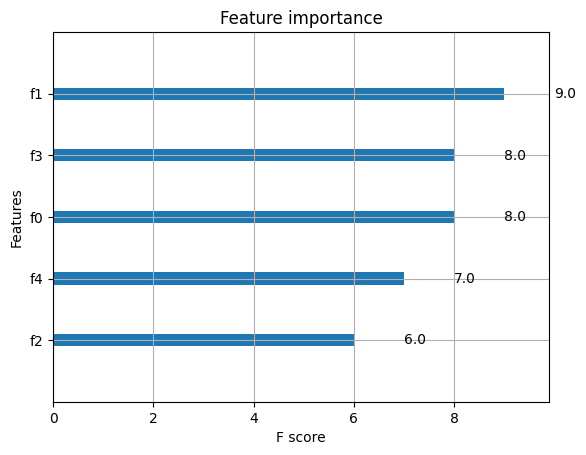

In [16]:
xgb.plot_importance(bst)

#### CROSS-VALIDATION AND OOT

In [17]:
datatrain = np.random.rand(1000, 10)
dataoot = np.random.rand(200, 10)

labeltrain = np.random.randint(2, size=1000)
labeloot = np.random.randint(2, size=200)

In [18]:
dtrain = xgb.DMatrix(data=datatrain, label=labeltrain, missing=np.NaN)
doot = xgb.DMatrix(data=dataoot, label=labeloot, missing=np.NaN)

In [10]:
params = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'binary:logistic',
    'nthread': 4
}

NUM_BOOST_ROUND = 500

In [19]:
res = xgb.cv(
    params, 
    dtrain, 
    NUM_BOOST_ROUND, 
    nfold=5, 
    metrics=['auc', 'aucpr'], 
    seed=222437, 
    callbacks=[
        xgb.callback.EvaluationMonitor(show_stdv=True),
        xgb.callback.EarlyStopping(5)
    ]
)

[0]	train-auc:0.55647+0.00953	train-aucpr:0.57708+0.02397	test-auc:0.49649+0.02882	test-aucpr:0.52253+0.01252
[1]	train-auc:0.59914+0.01265	train-aucpr:0.60745+0.02245	test-auc:0.49456+0.02853	test-aucpr:0.52663+0.02163
[2]	train-auc:0.63829+0.01484	train-aucpr:0.64722+0.01650	test-auc:0.48661+0.04454	test-aucpr:0.52861+0.01335
[3]	train-auc:0.66261+0.01058	train-aucpr:0.66830+0.01167	test-auc:0.52029+0.04140	test-aucpr:0.55483+0.02502
[4]	train-auc:0.68336+0.01220	train-aucpr:0.69439+0.01197	test-auc:0.51997+0.03441	test-aucpr:0.55139+0.03425
[5]	train-auc:0.69910+0.01080	train-aucpr:0.70717+0.01466	test-auc:0.50591+0.01857	test-aucpr:0.54013+0.03517
[6]	train-auc:0.70976+0.01080	train-aucpr:0.72240+0.01110	test-auc:0.51224+0.02176	test-aucpr:0.54348+0.04185
[7]	train-auc:0.72729+0.00819	train-aucpr:0.73624+0.01045	test-auc:0.52051+0.02107	test-aucpr:0.55589+0.04255
[8]	train-auc:0.74275+0.01089	train-aucpr:0.75185+0.00881	test-auc:0.50883+0.02781	test-aucpr:0.54722+0.05089
[9]	train-

In [22]:
res

,train-auc-mean,train-auc-std,train-aucpr-mean,train-aucpr-std,test-auc-mean,test-auc-std,test-aucpr-mean,test-aucpr-std
0,0.556470,0.009534,0.577082,0.023972,0.496490,0.028815,0.522534,0.012522
1,0.599144,0.012653,0.607454,0.022448,0.494562,0.028526,0.526635,0.021635
2,0.638286,0.014843,0.647217,0.016498,0.486609,0.044537,0.528613,0.013351
3,0.662606,0.010579,0.668297,0.011673,0.520289,0.041399,0.554833,0.025017
4,0.683358,0.012200,0.694390,0.011973,0.519974,0.034414,0.551391,0.034247
5,0.699100,0.010802,0.707166,0.014657,0.505906,0.018565,0.540129,0.035171
6,0.709756,0.010800,0.722399,0.011104,0.512239,0.021760,0.543479,0.041852
7,0.727293,0.008187,0.736236,0.010451,0.520511,0.021068,0.555886,0.042554


#### USING DATA ITERATOR WITH QUANTILE DMATRIX
- Passing batches of data into `xgboost.DeviceQuantileDMatrix` and use this `DeviceQuantileDMatrix` for training. The feature is used primarily designed to reduce the required GPU memory for training on distributed environment.

In [ ]:
import cupy

In [ ]:
COLS = 64
ROWS_PER_BATCH = 1000
BATCHES = 32
NUM_BOOST_ROUND = 500

In [ ]:
class IterForDMatrixDemo(xgb.core.DataIter):
    '''A data iterator for XGBoost DMatrix.

    `reset` and `next` are required for any data iterator, other functions here
    are utilites for demonstration's purpose.

    '''
    def __init__(self):
        '''Generate some random data for demostration.

        Actual data can be anything that is currently supported by XGBoost.
        '''
        self.rows = ROWS_PER_BATCH
        self.cols = COLS
        rng = cupy.random.RandomState(1994)
        self._data = [rng.randn(self.rows, self.cols)] * BATCHES
        self._labels = [rng.randn(self.rows)] * BATCHES
        self._weights = [rng.uniform(size=self.rows)] * BATCHES

        self.it = 0
        super().__init__()
        
    def data(self):
        '''Utility function for obtaining current batch of data.'''
        return self._data[self.it]

    def labels(self):
        '''Utility function for obtaining current batch of label.'''
        return self._labels[self.it]

    def weights(self):
        '''Utility function for obtaining current batch of weights.'''
        return self._weights[self.it]

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == len(self._data):
            # Return 0 when there's no more batch.
            return 0
        input_data(
            data=self.data(), 
            label=self.labels(),
            weight=self.weights()
        )
        self.it += 1
        return 1

In [ ]:
it = IterForDMatrixDemo()
m_with_it = xgb.DeviceQuantileDMatrix(it)

In [ ]:
reg_with_it = xgb.train(
    param={
        'tree_method': 'gpu_hist'
    }, 
    m_with_it,
    num_boost_round=NUM_BOOST_ROUND
)

In [ ]:
predict_with_it = reg_with_it.predict(m_with_it)

#### SPARK ESTIMATOR INTERFACE

In [ ]:
import pyspark.sql.functions as f
from pyspark.sql.types import *

import optuna
from xgboost.spark import SparkXGBClassifier

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.functions import vector_to_array

In [ ]:
pdf = pd.DataFrame(
  data=np.concatenate((datatrain, labeltrain.reshape(-1, 1)), axis=1),
  columns=[f'f{str(x).zfill(2)}' for x in range(datatrain.shape[1])] + ['label']
)

df = spark.createDataFrame(pdf)

In [ ]:
vecassembler = VectorAssembler(
  inputCols=[f'f{str(x).zfill(2)}' for x in range(datatrain.shape[1])], 
  outputCol='features'
)

df = (
    vecassembler
    .transform(df)
    .select('features', 'label')
    .withColumn('validationIndicatorCol', f.rand(222437) > 0.7)
)
df.persist()

dftrain = df.filter("validationIndicatorCol = 1")
dftrain.persist()

dfvalidation = df.filter("validationIndicatorCol = 0")
dfvalidation.persist()

#(dftrain, dfvalidation) = df.randomSplit([0.7, 0.3], seed=222437)

In [ ]:
def objective(trial):
    params = {
        'n_estimators': 1000,
        'missing': np.NaN,
        'learning_rate': trial.suggest_float('eta', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }
    
    classifier = SparkXGBClassifier(**params)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    
    param_grid = (
        ParamGridBuilder()
        .addGrid(classifier.learning_rate, [params['learning_rate']])
        .addGrid(classifier.max_depth, [params['max_depth']])
        .addGrid(classifier.subsample, [params['subsample']])
        .addGrid(classifier.colsample_bytree, [params['colsample_bytree']])
        .build()
    )
    
    cv = CrossValidator(
        estimator=classifier,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5
    )
    cv_model = cv.fit(dftrain)
    
    score = cv_model.avgMetrics[0]
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
best_params = study.best_params

In [ ]:
classifier = SparkXGBClassifier(**best_params, early_stopping_rounds=20, validation_indicator_col='validationIndicatorCol', eval_metric='auc')
model = classifier.fit(df)

In [ ]:
bst = model.get_booster()

In [ ]:
model.get_feature_importances()

In [ ]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

score = evaluator.evaluate(model.transform(dfvalidation))
print(f'Test score: {score:.3f}')

In [ ]:
df = (
    model
    .transform(dfvalidation)
    .select(
      f.col('label'),
      vector_to_array(f.col('probability'))[1].alias('probability')
    )
)